In [1]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Training of the CNN model

## Loading the image data into the memory

In [2]:
# For images with the puck
with_puck_img=[]
label_with_puck_img=[]
for img in glob.glob("..\Training_images\images_with_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    with_puck_img.append(n)
    label_with_puck_img.append(1)

without_puck_img=[]
label_without_puck_img=[]
for img in glob.glob("..\Training_images\images_without_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    without_puck_img.append(n)
    label_without_puck_img.append(0)

with_puck_img  = np.array(with_puck_img) 
label_with_puck_img  = np.array(label_with_puck_img) 
without_puck_img  = np.array(without_puck_img) 
label_without_puck_img  = np.array(label_without_puck_img) 

print(f'Total number of puck images: {len(with_puck_img)}')
print(f'Total number of without puck images: {len(without_puck_img)}')



Total number of puck images: 53
Total number of without puck images: 49


In [3]:
X = np.concatenate((with_puck_img,without_puck_img ), axis=0)/255.0
y = np.concatenate((label_with_puck_img,label_without_puck_img ), axis=0)

## Train-test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Visualizing the images 

Images belonging to 'rondelle'  : Label=1 \
Images NOT belonging to 'rondelle'  : Label=0

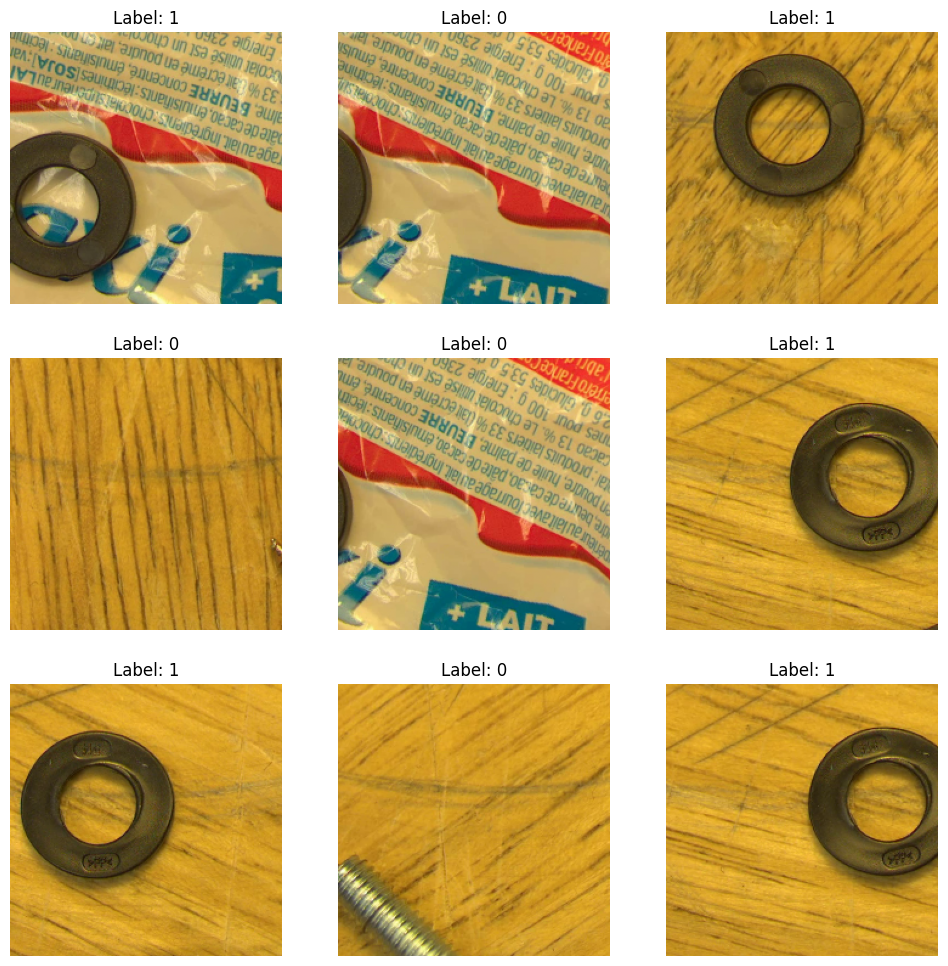

In [5]:

# Function to plot images
def plot_images(images, labels):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()


# Display the images
plot_images(X_train, y_train)

## Transfer learning with a pre-trained Mobile-net model with imagenet weights

In [6]:
# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3))
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False
# Create the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore weights from the epoch with the best value of the monitored quantity
)

# Train the model
history = model.fit(
    X_train,y_train,
    epochs=50,  # You can adjust the number of epochs
    batch_size=16,
    validation_data=(X_test,y_test),
    callbacks=[early_stopping]
)

# Save the model
model.save(r'../Trained_models/mobile_net_transfer_learning.h5')

Epoch 1/50
5/5 [==============================] - 9s 1s/step - loss: 0.5420 - accuracy: 0.6471 - val_loss: 0.1024 - val_accuracy: 1.0000
Epoch 2/50
5/5 [==============================] - 1s 263ms/step - loss: 0.0935 - accuracy: 0.9706 - val_loss: 0.0288 - val_accuracy: 1.0000
Epoch 3/50
5/5 [==============================] - 1s 259ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 4/50
5/5 [==============================] - 1s 263ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 5/50
5/5 [==============================] - 1s 263ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/50
5/5 [==============================] - 1s 259ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/50
5/5 [==============================] - 1s 259ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 8/50
5/5 [=======

c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


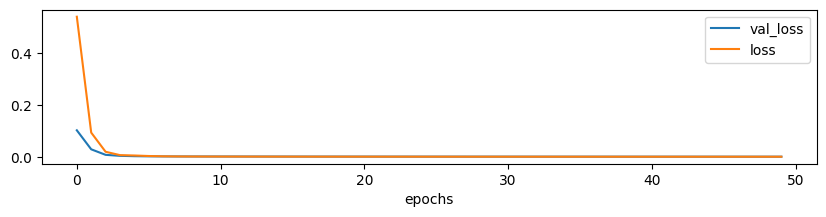

In [7]:
plt.figure(figsize=(10,2))
plt.plot(history.history['val_loss'],label='val_loss')
plt.plot(history.history['loss'],label='loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

## Display the predictions using the trained neural network

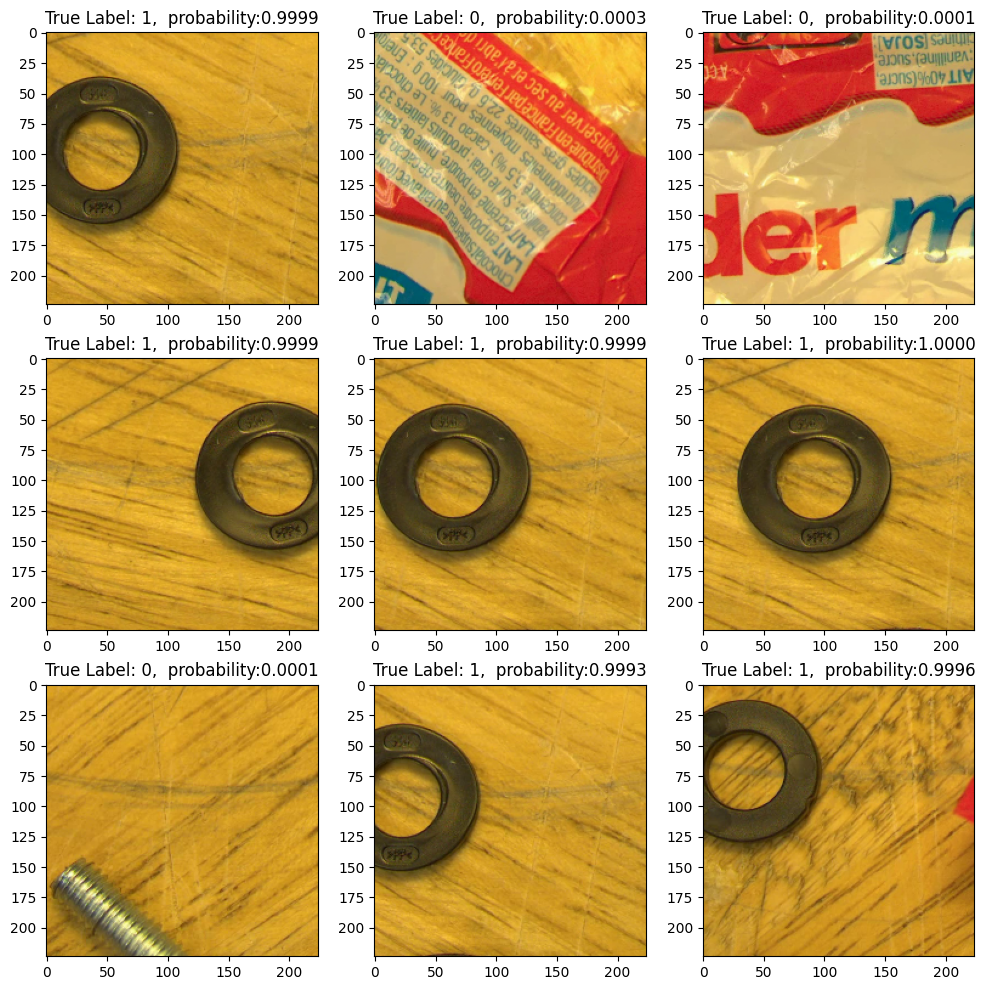

In [8]:
# Load the trained model
model = tf.keras.models.load_model(r'../Trained_models/mobile_net_transfer_learning.h5')

# Predict the labels using the model
predicted_labels = model.predict(X_test)

# Convert predicted labels to binary (0 or 1) based on a threshold (e.g., 0.5)
predicted_labels_binary = np.round(predicted_labels)

# Display a sample of images with true and predicted labels
num_samples_to_display = 9

plt.figure(figsize=(12, 12))
for i in range(num_samples_to_display):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'True Label: {int(y_test[i])},  probability:{predicted_labels[i][0]:.4f}')
plt.show()

# Selection of threshold using visual method

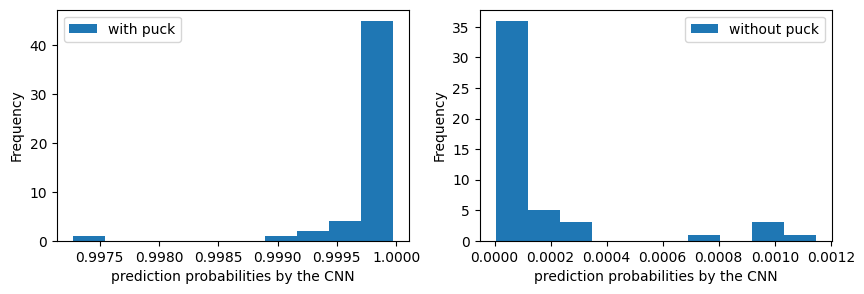

In [9]:
# Predictions using the trained model on images with and without puck

# Predictions for images with puck
probabilities_with_puck = model.predict(with_puck_img / 255.0)

# Predictions for images without puck
probabilities_without_puck = model.predict(without_puck_img / 255.0)

# Plot histograms for visualization

# Histogram for images with puck and without puck predictions
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(probabilities_with_puck, label='with puck', alpha=1)
plt.xlabel('prediction probabilities by the CNN')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(1,2,2)
plt.hist(probabilities_without_puck, label='without puck', alpha=1)
plt.xlabel('prediction probabilities by the CNN')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Reatime prediction

In [2]:

# Load the pretrained model
model = tf.keras.models.load_model(r'../Trained_models/mobile_net_transfer_learning.h5')
# Replace 'your_video_file.mp4' with the actual path to your video file
video_file_path = r'../videos_plateau_train_val/val.avi'

# Open the video file
cap = cv2.VideoCapture(video_file_path)


# Get the original frame dimensions
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Set the desired window dimensions
window_width = 800
window_height = int(window_width * (frame_height / frame_width))

# Create a window with the desired dimensions
cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Video', window_width, window_height)

# Define the coordinates of the rectangle
rect_start = (int(0.35 * window_width), int(0.5 * window_height))
rect_end = (int(0.55 * window_width), int(0.75 * window_height))

# Read and display the video frame by frame
while True:
    # Read a frame
    ret, frame = cap.read()

    # Resize the frame
    frame = cv2.resize(frame, (window_width, window_height))

    # Crop the region inside the rectangle
    cropped_region = frame[rect_start[1]:rect_end[1], rect_start[0]:rect_end[0]]

    # Preprocess the cropped region and make a prediction
    cropped_region = cv2.resize(cropped_region, (224, 224))
    cropped_region = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB)
    cropped_region = cropped_region / 255.0  # Normalize pixel values
    cropped_region = np.expand_dims(cropped_region, axis=0)  # Add batch dimension
    prediction = model.predict(cropped_region)[0, 0]

    # Update the rectangle color based on the prediction
    if prediction > 0.995:
        rect_color = (0, 255, 0)  # Green rectangle for 0 output
    else:
        rect_color = (0, 0, 255)  # Red rectangle for 1 output

    # Draw the rectangle on the frame
    cv2.rectangle(frame, rect_start, rect_end, rect_color, 2)

    # Display the prediction value near the rectangle
    cv2.putText(frame, f'Prediction: {prediction:.4f}', (rect_start[0], rect_start[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Video', frame)

    # Break the loop if the user presses 'q'
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
cap.release()
cv2.destroyAllWindows()


# Evaluate on the Val_video data

In [10]:
with_puck_img=[]
label_with_puck_img=[]
for img in glob.glob("..\Test_images\images_with_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    with_puck_img.append(n)
    label_with_puck_img.append(1)

without_puck_img=[]
label_without_puck_img=[]
for img in glob.glob("..\Test_images\images_without_puck\*.png"):
    n = cv2.imread(img)
    n = cv2.resize(n, (224, 224))
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    without_puck_img.append(n)
    label_without_puck_img.append(0)

with_puck_img  = np.array(with_puck_img) 
label_with_puck_img  = np.array(label_with_puck_img) 
without_puck_img  = np.array(without_puck_img) 
label_without_puck_img  = np.array(label_without_puck_img) 

print(f'Total number of puck images: {len(with_puck_img)}')
print(f'Total number of without puck images: {len(without_puck_img)}')


# Create the test dataset
X_test = np.concatenate((with_puck_img, without_puck_img), axis=0) / 255.0
y_test = np.concatenate((label_with_puck_img, label_without_puck_img), axis=0)

# Predictions on the test dataset
y_true = y_test
y_pred = model.predict(X_test)

Total number of puck images: 97
Total number of without puck images: 828


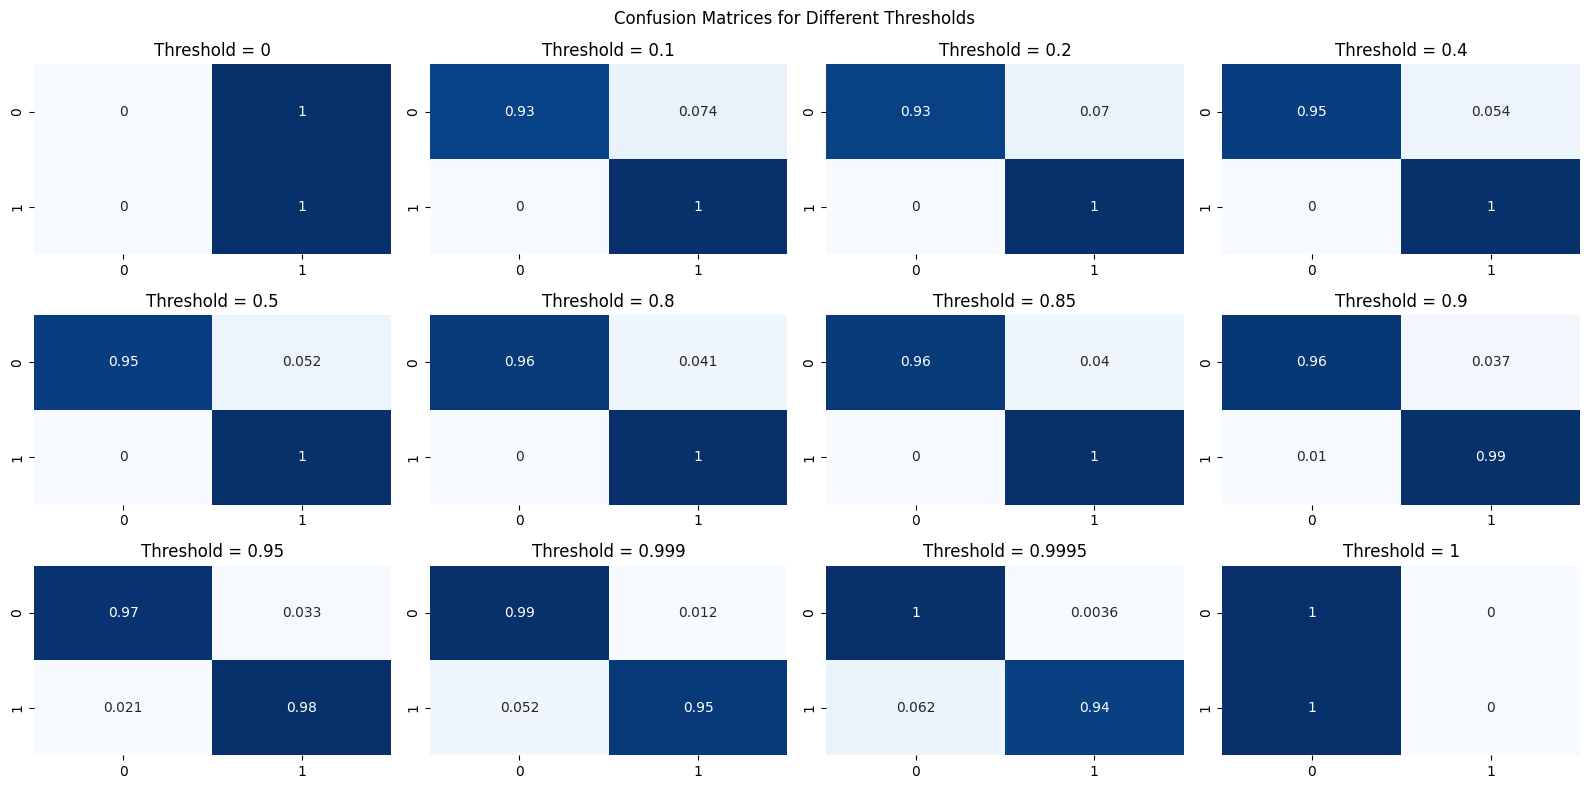

In [11]:
# Compute confusion matrix for different thresholds
thresholds = [0,0.1, 0.2, 0.4, 0.5, 0.8, 0.85, 0.9, 0.95, 0.999, 0.9995, 1]
conf_matrices = []

# Iterate through each threshold
for threshold in thresholds:
    # Threshold predictions based on the current threshold value
    y_pred_thresholded = (y_pred > threshold).astype(int)
    
    # Compute confusion matrix and normalize by true class labels
    conf_matrix = confusion_matrix(y_true, y_pred_thresholded, normalize='true')
    
    # Append the resulting confusion matrix to the list
    conf_matrices.append(conf_matrix)

# Plot confusion matrices
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
fig.suptitle('Confusion Matrices for Different Thresholds')

# Display each confusion matrix in a subplot
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(conf_matrices[i], annot=True, cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'Threshold = {thresholds[i]}')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


# Save the results as a pandas dataframe for later use

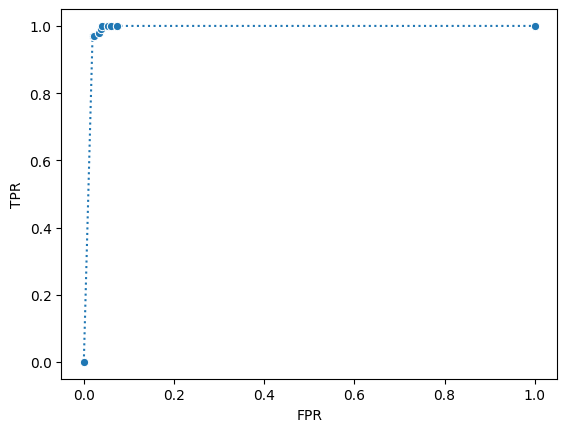

In [12]:
import pandas as pd

thresholds = [ 0, 0.1, 0.3, 0.4,0.8, 0.9, 0.95, 0.99, 0.995, 1]

results = pd.DataFrame(columns=('thresholds','TPR','FPR'))

for idx,threshold in enumerate(thresholds):
    y_pred_thresholded = (y_pred > threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred_thresholded,normalize=None)
    TP,FP,TN,FN= conf_matrix[1,1],conf_matrix[0,1],conf_matrix[0,0],conf_matrix[1,0]
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)

    
    results.loc[idx] = [threshold,TPR,FPR]

results.to_csv('../ROC_curve_test_set/mobile_net_model.csv',index=False)


sns.lineplot(data=results,x='FPR',y='TPR',  marker='o', linestyle='dotted')
plt.show()

In [13]:
results

,thresholds,TPR,FPR
0,0.000,1.000000,1.000000
1,0.100,1.000000,0.073671
2,0.300,1.000000,0.060386
3,0.400,1.000000,0.054348
4,0.800,1.000000,0.041063
5,0.900,0.989691,0.037440
6,0.950,0.979381,0.032609
7,0.990,0.969072,0.022947
8,0.995,0.969072,0.019324
9,1.000,0.000000,0.000000
